In [1]:
import pickle
import os
import time
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from numpy import linalg as LA
import numpy as np
import math

In [2]:
class LinearDataset(Dataset):
    def __init__(self, X, y):
        assert X.size()[0] == y.size()[0]
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.size()[0]
    
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [3]:
X = torch.Tensor([[1,1],[-1,1],[0,1]])
Y = torch.Tensor([[1],[1],[0]])
print(Y.size())

torch.Size([3, 1])


In [4]:
device='cpu'

class LR(nn.Module):
    def __init__(self, input_size=2, num_class=1):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(input_size, num_class)
        self.act=nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        return (x)

In [5]:
train_loader = torch.utils.data.DataLoader(LinearDataset(X, Y), batch_size=len(train_imgs))

In [6]:
model = LR().to(device).double()

In [18]:
state_dict = model.state_dict()
print(state_dict['fc1.weight'].size())
state_dict['fc1.weight'] = torch.Tensor([[0., 2*(math.log(2,math.e))]])/1.1
state_dict['fc1.bias'] = torch.Tensor([0])
model.load_state_dict(state_dict)

torch.Size([1, 2])


<All keys matched successfully>

In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
        #print(name, param.data)
        break
     

In [20]:
from scipy.special import lambertw
import math
lambert_w = lambertw(1/math.e)

def autograd(outputs, inputs, create_graph=False):
    """Compute gradient of outputs w.r.t. inputs, assuming outputs is a scalar."""
    #inputs = tuple(inputs)
    grads = torch.autograd.grad(outputs, inputs, create_graph=create_graph, allow_unused=True)
    return [xx if xx is not None else yy.new_zeros(yy.size()) for xx, yy in zip(grads, inputs)]

def tau(epoch,lr):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).double(), target.to(device).double()

        # initialize f function
        criterion = nn.BCELoss()
        
        # calculate gradient of w on clean sample
        output_c = model(data.view(data.size(0), -1))
        #output_c = model(data)
        loss_c = criterion(output_c,target)
        # wrt to w here
        grad_c= autograd(loss_c,tuple(model.parameters()),create_graph=True)
        print(grad_c[0].size())
        g1 = grad_c[0]
        #loss_c.backward()
        #g1= model.fc1.weight.grad
        torch.save(g1.detach(), 'gmu.pt')
        print(g1.detach())
        
        g1 = torch.flatten(g1)
        
        
        
        
        w_p = model.fc1.weight
        print(w_p)
        
        w_p = torch.flatten(w_p)
        #g1 = g1/len(target)
        g_mu_dot_w = np.dot(g1.cpu().detach().numpy().squeeze(),w_p.cpu().detach().numpy().squeeze())
        print(g_mu_dot_w)
        
        print('the necessary size of epsilon_d:{}'.format(g_mu_dot_w/lambert_w))
        break
            

        
        
print("==> start gradient canceling attack with given target parameters")
print("==> model will be saved in poisoned_models")
epochs=20
lr=1
for epoch in range(epochs):
    tau(epoch,lr)
    break
    

==> start gradient canceling attack with given target parameters
==> model will be saved in poisoned_models
torch.Size([1, 2])
tensor([[0.0000, 0.1124]], dtype=torch.float64)
Parameter containing:
tensor([[0.0000, 1.2603]], dtype=torch.float64, requires_grad=True)
0.14166101919673285
the necessary size of epsilon_d:(0.5087219284441533+0j)


In [21]:
optimizer = optim.Adadelta(model.parameters(), lr=0.1)
# define epsilon for one point for now
epsilon = 0.52


# load gmu to initialize the poisoned samples
gmu = torch.load('gmu.pt')
print(gmu.size())

def attack(epoch,lr):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).double(), target.to(device).double()
        data.requires_grad=True
        if epoch==0:
            # initialize poisoned data with 1/epsilon g(mu)
            #data_p = Variable(data[:epsilon])
            data_p = Variable((gmu))
            target_p = Variable(torch.ones([1,1])).double()
            torch.save(target_p,'target_p_{}.pt'.format(epsilon))
        else:
            data_p = torch.load('data_p_{}.pt'.format(epsilon))
            target_p = torch.load('target_p_{}.pt'.format(epsilon))
        data_p.requires_grad=True
        # initialize f function with average
        criterion = nn.BCELoss()
        
        # calculate gradient of w on clean sample
        output_c = model(data.view(data.size(0), -1))
        #output_c = model(data)
        loss_c = criterion(output_c,target)
        #print(loss_c)
        # wrt to w here
        grad_c= autograd(loss_c,tuple(model.parameters()),create_graph=True)
        g1 = grad_c[0]
        #print(g1)
        
        
        # calculate gradient of w on poisoned sample
        #print(data_p)
        output_p = model(data_p.view(data_p.size(0), -1))

        loss_p = criterion(output_p,target_p)
        grad_p= autograd(loss_p,tuple(model.parameters()),create_graph=True)
        g2 = grad_p[0]
        # calculate the true loss: |g_c + g_p|_{inf}
        
        grad_sum = g1+(epsilon*g2)

        
        loss = torch.norm(grad_sum,2).square()
        loss_eps.append(loss.detach().cpu().numpy())
            
        update = autograd(loss,data_p,create_graph=True)
        #print(update)
        
        data_t = data_p - lr * update[0]

        torch.save(data_t, 'data_p_{}.pt'.format(epsilon))
        
        
        print("epoch:{},loss:{},lr:{}".format(epoch, loss,lr))

        
        
print("==> start gradient canceling attack with given target parameters")
print("==> model will be saved in poisoned_models")
epochs=2000
    

torch.Size([1, 2])
==> start gradient canceling attack with given target parameters
==> model will be saved in poisoned_models


In [24]:
loss_eps=[]
lr =1
for epoch in range(epochs):
    attack(epoch,lr)

epoch:0,loss:0.007266995072478959,lr:1
epoch:1,loss:0.005926007810231005,lr:1
epoch:2,loss:0.004941554531040222,lr:1
epoch:3,loss:0.004194701303095636,lr:1
epoch:4,loss:0.0036129170140314225,lr:1
epoch:5,loss:0.0031497493958916414,lr:1
epoch:6,loss:0.00277423458339715,lr:1
epoch:7,loss:0.002465034077729018,lr:1
epoch:8,loss:0.0022070224642755185,lr:1
epoch:9,loss:0.001989216233819746,lr:1
epoch:10,loss:0.0018034707438895434,lr:1
epoch:11,loss:0.0016436346668311642,lr:1
epoch:12,loss:0.0015049862806718168,lr:1
epoch:13,loss:0.0013838486105413738,lr:1
epoch:14,loss:0.0012773210689639087,lr:1
epoch:15,loss:0.0011830887651844988,lr:1
epoch:16,loss:0.0010992846851647943,lr:1
epoch:17,loss:0.001024388542934284,lr:1
epoch:18,loss:0.0009571515031687836,lr:1
epoch:19,loss:0.0008965394400318327,lr:1
epoch:20,loss:0.0008416896659612208,lr:1
epoch:21,loss:0.000791877576607608,lr:1
epoch:22,loss:0.0007464906834807329,lr:1
epoch:23,loss:0.0007050082116810828,lr:1
epoch:24,loss:0.0006669849328855786,

In [12]:
lr= [0.01,0.1,1,10,100]
loss_all=[]
for lr_ins in lr:
    loss_lr=[]
    for epoch in range(epochs):
        attack(epoch,lr_ins)
    loss_all.append(loss_lr)

epoch:0,loss:0.010375756351742527,lr:0.01
epoch:1,loss:0.01035708070219902,lr:0.01
epoch:2,loss:0.01033846555111946,lr:0.01
epoch:3,loss:0.010319910627208991,lr:0.01
epoch:4,loss:0.010301415660713744,lr:0.01
epoch:5,loss:0.010282980383410316,lr:0.01
epoch:6,loss:0.01026460452859529,lr:0.01
epoch:7,loss:0.01024628783107487,lr:0.01
epoch:8,loss:0.0102280300271546,lr:0.01
epoch:9,loss:0.01020983085462914,lr:0.01
epoch:10,loss:0.010191690052772151,lr:0.01
epoch:11,loss:0.010173607362326238,lr:0.01
epoch:12,loss:0.010155582525492982,lr:0.01
epoch:13,loss:0.010137615285923062,lr:0.01
epoch:14,loss:0.01011970538870644,lr:0.01
epoch:15,loss:0.010101852580362615,lr:0.01
epoch:16,loss:0.010084056608830992,lr:0.01
epoch:17,loss:0.010066317223461265,lr:0.01
epoch:18,loss:0.010048634175003944,lr:0.01
epoch:19,loss:0.010031007215600919,lr:0.01
epoch:20,loss:0.010013436098776085,lr:0.01
epoch:21,loss:0.009995920579426073,lr:0.01
epoch:22,loss:0.009978460413811039,lr:0.01
epoch:23,loss:0.0099610553595

In [13]:
len(loss_all)

5

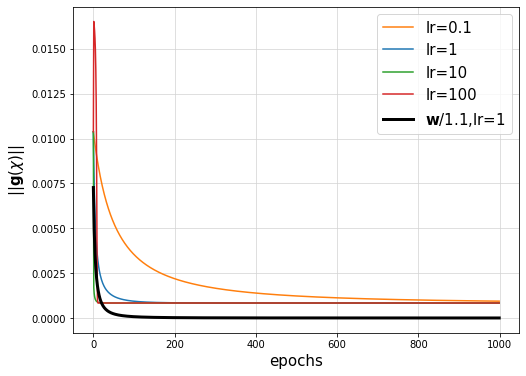

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax = plt.gca()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(10)
#plt.plot([x for x in loss_all[0]])
plt.plot([x for x in loss_all[1][:1000]], label='lr=0.1', color='C1',linewidth=1.5)
plt.plot([x for x in loss_all[2][:1000]],label='lr=1', color='C0',linewidth=1.5)
plt.plot([x for x in loss_all[3][:1000]], label='lr=10',color='C2',linewidth=1.5)
plt.plot([x for x in loss_all[4][:1000]], label='lr=100',color='C3',linewidth=1.5)
plt.plot(loss_eps[:1000],label=r'$\mathbf{w}/1.1$,lr=1', color='black',linewidth=3)
#plt.savefig('poisoned_models/cnn/img/retrain_loss_{}.png'.format(epsilon))
ax.legend(fontsize=15)
plt.grid(color='lightgray', alpha=0.9, zorder=1)
plt.ylabel(r'$||\mathbf{g}(\chi)\||$',fontsize=15)
plt.xlabel('epochs',fontsize=15)
plt.savefig('scaling.png',dpi=700)
plt.show()